# Build a Minimal Recommendation Engine

In this project, I explore the method to build a basic recommendation engine following a tutorial in the reference. And the dataset is from https://movielens.org/.
There're two types of recommedation methods: 
- content-based filtering: recommand based on the user's own rating history on one movie. 
   <p>-- Content-based filtering methods are based on a description of the item and a profile of the user’s preferences.</p>
- collaborative filtering: recommand based on other user's rating history on one movie. 
   <p>-- Collaborative filtering methods are based on collecting and analyzing a large amount of information on users’ behaviors, activities or preferences and predicting what users will like based on their similarity to other users.</p>

## 1. The MovieLens dataset: loading and first look

In [2]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
movies = pd.read_csv(r'ml-latest-small/movies.csv')
ratings = pd.read_csv(r'ml-latest-small/ratings.csv')
links = pd.read_csv(r'ml-latest-small/links.csv')
tags = pd.read_csv(r'ml-latest-small/tags.csv')
#genome_tags = pd.read_csv(r'ml-latest-small/genome-tags.csv')
#genome_scores = pd.read_csv(r'ml-latest-small/genome-scores.csv')

In [186]:
type(movies),type(ratings),type(links),type(tags)

(pandas.core.frame.DataFrame,
 pandas.core.frame.DataFrame,
 pandas.core.frame.DataFrame,
 pandas.core.frame.DataFrame)

In [5]:
print(movies.head(),movies.shape)

   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy   (9125, 3)


In [6]:
print(ratings.head(),ratings.shape)

   userId  movieId  rating   timestamp
0       1       31     2.5  1260759144
1       1     1029     3.0  1260759179
2       1     1061     3.0  1260759182
3       1     1129     2.0  1260759185
4       1     1172     4.0  1260759205 (100004, 4)


In [7]:
print('How many users rated movies?',len(ratings['userId'].unique()))

How many users rated movies? 671


In [8]:
print('How many movies are rated?',len(ratings['movieId'].unique()))

How many movies are rated? 9066


In [9]:
print(links.head(),links.shape)

   movieId  imdbId   tmdbId
0        1  114709    862.0
1        2  113497   8844.0
2        3  113228  15602.0
3        4  114885  31357.0
4        5  113041  11862.0 (9125, 3)


In [10]:
print(tags.head(),tags.shape)

   userId  movieId                      tag   timestamp
0      15      339  sandra 'boring' bullock  1138537770
1      15     1955                  dentist  1193435061
2      15     7478                 Cambodia  1170560997
3      15    32892                  Russian  1170626366
4      15    34162              forgettable  1141391765 (1296, 4)


In [11]:
print('How many movies have tags?', len(tags['movieId'].unique()))

How many movies have tags? 689


## 2. Wrangling the movie dataset

### Merge the datasets together

In [12]:
movies_links = pd.merge(movies,links)
print(movies_links.head())
movies_links.shape

   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  imdbId   tmdbId  
0  Adventure|Animation|Children|Comedy|Fantasy  114709    862.0  
1                   Adventure|Children|Fantasy  113497   8844.0  
2                               Comedy|Romance  113228  15602.0  
3                         Comedy|Drama|Romance  114885  31357.0  
4                                       Comedy  113041  11862.0  


(9125, 5)

In [13]:
movies_links_ratings = ratings.merge(movies_links,on='movieId',how='left')
#print(movies_links_ratings.sort_values(by=['movieId']).head())
#print(ratings[ratings.timestamp == 851866703])
#print(movies_links_ratings[movies_links_ratings.movieId == 850866703])
print(movies_links_ratings.head())

   userId  movieId  rating   timestamp  \
0       1       31     2.5  1260759144   
1       1     1029     3.0  1260759179   
2       1     1061     3.0  1260759182   
3       1     1129     2.0  1260759185   
4       1     1172     4.0  1260759205   

                                            title  \
0                          Dangerous Minds (1995)   
1                                    Dumbo (1941)   
2                                 Sleepers (1996)   
3                     Escape from New York (1981)   
4  Cinema Paradiso (Nuovo cinema Paradiso) (1989)   

                             genres  imdbId   tmdbId  
0                             Drama  112792   9909.0  
1  Animation|Children|Drama|Musical   33563  11360.0  
2                          Thriller  117665    819.0  
3  Action|Adventure|Sci-Fi|Thriller   82340   1103.0  
4                             Drama   95765  11216.0  


In [14]:
movielens_1 = movies_links_ratings.merge(tags,on=['userId','movieId'],how='left')
print(movielens_1.head())

   userId  movieId  rating  timestamp_x  \
0       1       31     2.5   1260759144   
1       1     1029     3.0   1260759179   
2       1     1061     3.0   1260759182   
3       1     1129     2.0   1260759185   
4       1     1172     4.0   1260759205   

                                            title  \
0                          Dangerous Minds (1995)   
1                                    Dumbo (1941)   
2                                 Sleepers (1996)   
3                     Escape from New York (1981)   
4  Cinema Paradiso (Nuovo cinema Paradiso) (1989)   

                             genres  imdbId   tmdbId  tag  timestamp_y  
0                             Drama  112792   9909.0  NaN          NaN  
1  Animation|Children|Drama|Musical   33563  11360.0  NaN          NaN  
2                          Thriller  117665    819.0  NaN          NaN  
3  Action|Adventure|Sci-Fi|Thriller   82340   1103.0  NaN          NaN  
4                             Drama   95765  11216.0  NaN

### Transfer the timestamps into datetime

In [15]:
datetime.datetime.fromtimestamp(int('1260759144')).strftime("%Y-%m-%d %H:%M:%S")

'2009-12-13 21:52:24'

In [16]:
def get_datetime(timestamp_array):
    result = []
    for i in timestamp_array:
        if not np.isnan(i):
            result.append(datetime.datetime.fromtimestamp(int(i)).strftime("%Y-%m-%d %H:%M:%S"))
        else:
            result.append(np.NaN)
    return result

In [17]:
movielens_1['timestamp_ratings'] = get_datetime(movielens_1.timestamp_x)
movielens_1['timestamp_tags'] = get_datetime(movielens_1.timestamp_y)
movielens_2 = movielens_1.drop(['timestamp_x'],axis=1)
movielens = movielens_2.drop(['timestamp_y'],axis=1)
#movielens = movielens.dropna()

In [18]:
print(movielens.head())

   userId  movieId  rating                                           title  \
0       1       31     2.5                          Dangerous Minds (1995)   
1       1     1029     3.0                                    Dumbo (1941)   
2       1     1061     3.0                                 Sleepers (1996)   
3       1     1129     2.0                     Escape from New York (1981)   
4       1     1172     4.0  Cinema Paradiso (Nuovo cinema Paradiso) (1989)   

                             genres  imdbId   tmdbId  tag  \
0                             Drama  112792   9909.0  NaN   
1  Animation|Children|Drama|Musical   33563  11360.0  NaN   
2                          Thriller  117665    819.0  NaN   
3  Action|Adventure|Sci-Fi|Thriller   82340   1103.0  NaN   
4                             Drama   95765  11216.0  NaN   

     timestamp_ratings timestamp_tags  
0  2009-12-13 21:52:24            NaN  
1  2009-12-13 21:52:59            NaN  
2  2009-12-13 21:53:02            NaN  
3  2

### Extract year of movies as a new cloumn

In [19]:
def representInt(string):
    try:
        int(string)
        return True
    except ValueError:
        return False

In [20]:
def get_year_1(string): 
    m,n = 0,0
    for i in range(len(string)):
        if (string[i] == '(') & (i < len(string)-1):
            if representInt(string[i+1]):
                m = i
        if (string[i] == ')') & representInt(string[i-1]):
            n = i
    return string[m+1:n]

In [21]:
def get_year(array):
    result = []
    for i in array:
        result.append(get_year_1(i))
    return result

In [22]:
movielens['year'] = get_year(movielens['title'])
print(movielens.head())

   userId  movieId  rating                                           title  \
0       1       31     2.5                          Dangerous Minds (1995)   
1       1     1029     3.0                                    Dumbo (1941)   
2       1     1061     3.0                                 Sleepers (1996)   
3       1     1129     2.0                     Escape from New York (1981)   
4       1     1172     4.0  Cinema Paradiso (Nuovo cinema Paradiso) (1989)   

                             genres  imdbId   tmdbId  tag  \
0                             Drama  112792   9909.0  NaN   
1  Animation|Children|Drama|Musical   33563  11360.0  NaN   
2                          Thriller  117665    819.0  NaN   
3  Action|Adventure|Sci-Fi|Thriller   82340   1103.0  NaN   
4                             Drama   95765  11216.0  NaN   

     timestamp_ratings timestamp_tags  year  
0  2009-12-13 21:52:24            NaN  1995  
1  2009-12-13 21:52:59            NaN  1941  
2  2009-12-13 21:53:02    

### Generate a smaller dataset in the interest of running time

In [41]:
movielens = movielens.ix[np.random.choice(movielens.index, size=10000, replace=False)]
print(movielens.shape)
print(movielens.userId.nunique())
print(movielens.movieId.nunique())

(10000, 11)
651
3516


C:\Users\Alexander\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  if __name__ == '__main__':


### Distribution of the year of movies

(array([  1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   1.00000000e+00,   4.00000000e+00,
          6.00000000e+00,   1.80000000e+01,   2.60000000e+01,
          5.60000000e+01,   8.30000000e+01,   3.80000000e+01,
          6.00000000e+01,   8.80000000e+01,   8.60000000e+01,
          1.10000000e+02,   1.32000000e+02,   1.58000000e+02,
          2.08000000e+02,   1.90000000e+02,   3.48000000e+02,
          5.35000000e+02,   7.26000000e+02,   1.04500000e+03,
          1.70500000e+03,   1.74400000e+03,   1.20800000e+03,
          6.61000000e+02,   4.70000000e+02,   2.55000000e+02]),
 array([ 1902. ,  1905.8,  1909.6,  1913.4,  1917.2,  1921. ,  1924.8,
         1928.6,  1932.4,  1936.2,  1940. ,  1943.8,  1947.6,  1951.4,
         1955.2,  1959. ,  1962.8,  1966.6,  1970.4,  1974.2,  1978. ,
         1981.8,  1985.6,  1989.4,  1993.2,  1997. ,  2000.8,  2004.6,
         2008.4,  2012.2,  2016. ]),
 <a list of 30 Patch objects>)

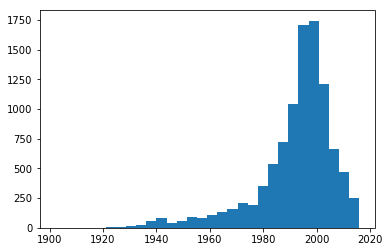

In [172]:
movie_year = []
for year in movielens['year']:
    if representInt(year): 
        y = int(year)
    movie_year.append(y)
#print(movie_year)
plt.hist(movie_year,bins=30)

In [159]:
movie_year[0] == 1978

True

In [187]:
movie_year_dict={}
for year in movie_year:
    if year in movie_year_dict.keys():
        movie_year_dict[year] +=1
    else:
        movie_year_dict[year] = 1

import operator
five_years_with_most_movies = sorted(movie_year_dict.items(), key=operator.itemgetter(1))[-5:]
print('The top five years with most movies and the number of movies: {}'.format(five_years_with_most_movies))

The top five years with most movies and the number of movies: [(1993, 451), (1996, 494), (1999, 521), (1994, 546), (1995, 665)]


In [42]:
def split_by(text):
    li = text.split('|')
    return li

In [43]:
genres_list = movies['genres'].apply(split_by)
#genres_series = genres_list.apply(pd.Series)
print(genres_list.head())

0    [Adventure, Animation, Children, Comedy, Fantasy]
1                       [Adventure, Children, Fantasy]
2                                    [Comedy, Romance]
3                             [Comedy, Drama, Romance]
4                                             [Comedy]
Name: genres, dtype: object


In [188]:
genres_total = set()
for l in genres_list:
    for e in l:
        if e != '(no genres listed)':
            genres_total.add(e)
print('Genres set:\n',genres_total)
print('\nHow many genres totally?\n',len(genres_total))

Genres set:
 {'Fantasy', 'Crime', 'Western', 'Animation', 'War', 'Documentary', 'Thriller', 'Adventure', 'Film-Noir', 'Children', 'Action', 'Romance', 'Horror', 'Mystery', 'IMAX', 'Musical', 'Sci-Fi', 'Comedy', 'Drama'}

How many genres totally?
 19


## 3. Apply the inferential statistics

In [26]:
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""

    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n

    return x, y

### If mean of one user's rating is 3.5, does this user tend to overestimate or underestimate a movie?

Null hypothesis: This user either tend to overestimate or tend to underestimates a movies.

3.630558517910068


(array([  1.,   0.,   0.,   0.,   0.,   3.,   0.,   0.,   1.,   1.,   0.,
          4.,   1.,   0.,   0.,   0.,   6.,   0.,   3.,   3.,   4.,   3.,
          9.,   6.,   4.,  10.,  12.,  37.,  10.,  21.,  33.,  30.,  32.,
         46.,  36.,  35.,  31.,  41.,  59.,  17.,  38.,  19.,  18.,  15.,
         29.,   5.,   9.,   4.,   3.,  12.]),
 array([ 0.5 ,  0.59,  0.68,  0.77,  0.86,  0.95,  1.04,  1.13,  1.22,
         1.31,  1.4 ,  1.49,  1.58,  1.67,  1.76,  1.85,  1.94,  2.03,
         2.12,  2.21,  2.3 ,  2.39,  2.48,  2.57,  2.66,  2.75,  2.84,
         2.93,  3.02,  3.11,  3.2 ,  3.29,  3.38,  3.47,  3.56,  3.65,
         3.74,  3.83,  3.92,  4.01,  4.1 ,  4.19,  4.28,  4.37,  4.46,
         4.55,  4.64,  4.73,  4.82,  4.91,  5.  ]),
 <a list of 50 Patch objects>)

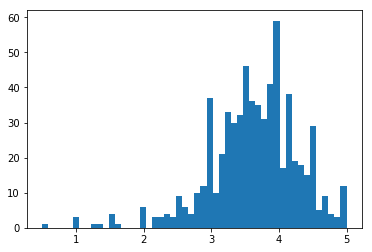

In [45]:
mean_rating_user = movielens.groupby('userId').mean()['rating']
print(mean_rating_user.mean())
plt.hist(mean_rating_user,bins=50)

3.630558517910068
0.6633781437561124


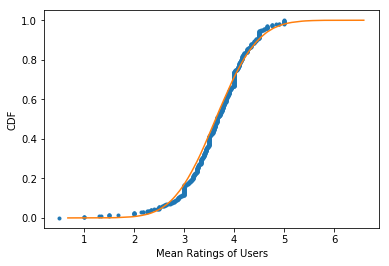

In [46]:
mean_user = np.mean(mean_rating_user)
std_user = np.std(mean_rating_user)
samples_user = np.random.normal(mean_user,std_user,100000)
x_theor_user, y_theor_user = ecdf(samples_user)
x_user, y_user = ecdf(mean_rating_user)
print(mean_user)
print(std_user)
_ = plt.plot(x_user, y_user, marker='.', linestyle='none')
_ = plt.plot(x_theor_user, y_theor_user)
_ = plt.xlabel('Mean Ratings of Users')
_ = plt.ylabel('CDF')

In this situation, it is appropriate to use the z statistic, because the value of mean is approximately a normal distribution.

In [29]:
def bootstrap_replicate_1d(data,func):
    bs_sample = np.random.choice(data,len(data))
    return func(bs_sample)
def draw_bs_reps(data,func,size=1):
    bs = np.empty(size)
    for i in range(size):
        bs[i] = bootstrap_replicate_1d(data,func)
    return bs

SEM is:  0.0259998393476
Standard deviation is:  0.0259936181183


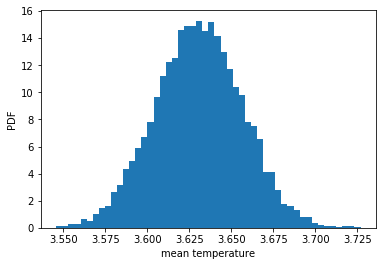

In [47]:
bs_replicates = draw_bs_reps(mean_rating_user,np.mean,size=10000)

# Compute and print SEM
sem = np.std(mean_rating_user) / np.sqrt(len(mean_rating_user))
print('SEM is: ', sem)

# Compute and print standard deviation of bootstrap replicates
bs_std = np.std(bs_replicates)
print('Standard deviation is: ', bs_std)

# Make a histogram of the results
_ = plt.hist(bs_replicates, bins=50, normed=True)
_ = plt.xlabel('mean temperature')
_ = plt.ylabel('PDF')

# Show the plot
plt.show()

In [48]:
z_score = (3.5 - np.mean(mean_rating_user))/sem
print('z score:', z_score)
from scipy import stats
p = (1-stats.norm.cdf(abs(z_score)))*2
print('p value:',p)

z score: -5.02151248569
p value: 5.12661706198e-07


According to the z score and p value above, if mean rating of a user is 3.5, he or she tends to underestimate a movie.

### If one movie's rating is 3.5, is this movie beyond the average or below the average?

Null hypothesis: This movie's rating, 3.5, is just average.

(array([  29.,    0.,    2.,    0.,    0.,  103.,    0.,    4.,    2.,
           3.,    0.,   58.,    4.,   10.,    1.,    2.,  200.,    1.,
          14.,   34.,   13.,    4.,  202.,   13.,   19.,   68.,   19.,
         478.,   12.,   45.,  113.,   67.,   37.,  394.,   56.,   72.,
          99.,   82.,  634.,   17.,   55.,   68.,   45.,   13.,  170.,
           8.,   18.,   15.,    0.,  213.]),
 array([ 0.5 ,  0.59,  0.68,  0.77,  0.86,  0.95,  1.04,  1.13,  1.22,
         1.31,  1.4 ,  1.49,  1.58,  1.67,  1.76,  1.85,  1.94,  2.03,
         2.12,  2.21,  2.3 ,  2.39,  2.48,  2.57,  2.66,  2.75,  2.84,
         2.93,  3.02,  3.11,  3.2 ,  3.29,  3.38,  3.47,  3.56,  3.65,
         3.74,  3.83,  3.92,  4.01,  4.1 ,  4.19,  4.28,  4.37,  4.46,
         4.55,  4.64,  4.73,  4.82,  4.91,  5.  ]),
 <a list of 50 Patch objects>)

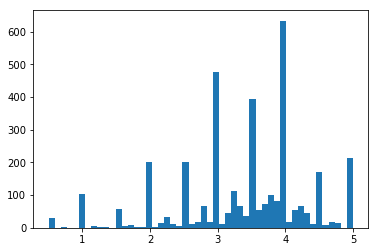

In [49]:
mean_rating_movies = movielens.groupby('movieId').mean()['rating']
plt.hist(mean_rating_movies,bins=50)

3.3815113224661366
0.9465436522238613


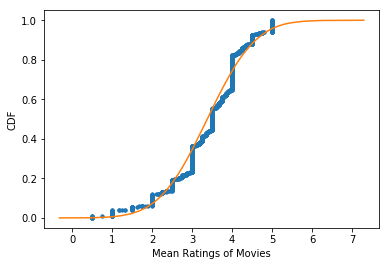

In [50]:
mean_movies = np.mean(mean_rating_movies)
std_movies = np.std(mean_rating_movies)
samples_movies = np.random.normal(mean_movies,std_movies,100000)
x_theor_movies, y_theor_movies = ecdf(samples_movies)
x_movies, y_movies = ecdf(mean_rating_movies)
print(mean_movies)
print(std_movies)
_ = plt.plot(x_movies, y_movies, marker='.', linestyle='none')
_ = plt.plot(x_theor_movies, y_theor_movies)
_ = plt.xlabel('Mean Ratings of Movies')
_ = plt.ylabel('CDF')

SEM is:  0.0159630625036
Standard deviation is:  0.0159801978842


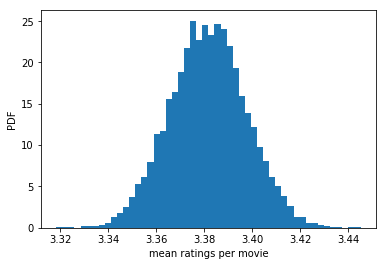

In [51]:
bs_replicates_movies = draw_bs_reps(mean_rating_movies,np.mean,size=10000)

# Compute and print SEM
sem_movies = np.std(mean_rating_movies) / np.sqrt(len(mean_rating_movies))
print('SEM is: ', sem_movies)

# Compute and print standard deviation of bootstrap replicates
bs_std_movies = np.std(bs_replicates_movies)
print('Standard deviation is: ', bs_std_movies)

# Make a histogram of the results
_ = plt.hist(bs_replicates_movies, bins=50, normed=True)
_ = plt.xlabel('mean ratings per movie')
_ = plt.ylabel('PDF')

# Show the plot
plt.show()

In [52]:
z_score_movies = (3.5 - np.mean(mean_rating_movies))/sem_movies
print('z score:', z_score_movies)
from scipy import stats
p_movies = (1-stats.norm.cdf(abs(z_score_movies)))*2
print('p value:',p_movies)

z score: 7.42267829289
p value: 1.14797060746e-13


According to the z score and p value, if a movie's rating is 3.5, it's significantly higher rated.

In [36]:
ratings_reshape = ratings[['userId','movieId','rating']].pivot(index='movieId',columns='userId',values='rating')
print(ratings_reshape.head())

userId   1    2    3    4    5    6    7    8    9    10  ...   662  663  664  \
movieId                                                   ...                   
1        NaN  NaN  NaN  NaN  NaN  NaN  3.0  NaN  4.0  NaN ...   NaN  4.0  3.5   
2        NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN ...   5.0  NaN  NaN   
3        NaN  NaN  NaN  NaN  4.0  NaN  NaN  NaN  NaN  NaN ...   NaN  NaN  NaN   
4        NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN ...   NaN  NaN  NaN   
5        NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN ...   NaN  NaN  NaN   

userId   665  666  667  668  669  670  671  
movieId                                     
1        NaN  NaN  NaN  NaN  NaN  4.0  5.0  
2        3.0  NaN  NaN  NaN  NaN  NaN  NaN  
3        3.0  NaN  NaN  NaN  NaN  NaN  NaN  
4        NaN  NaN  NaN  NaN  NaN  NaN  NaN  
5        3.0  NaN  NaN  NaN  NaN  NaN  NaN  

[5 rows x 671 columns]


## 4. Minimal reco engine and its evaluation

### Delete the users who only rate once

In [53]:
user_ids_larger_1 = pd.value_counts(movielens.userId, sort=False) > 1
user_ids_larger_1 = user_ids_larger_1[user_ids_larger_1].index

movielens = movielens.select(lambda l: movielens.loc[l, 'userId'] in user_ids_larger_1)
print(movielens.shape)
assert(np.all(movielens.userId.value_counts() > 1))

(9962, 11)


In [54]:
movielens.head()

,userId,movieId,rating,title,genres,imdbId,tmdbId,tag,timestamp_ratings,timestamp_tags,year
19613,130,2640,3.0,Superman (1978),Action|Adventure|Sci-Fi,78346,1924.0,NaN,2006-02-03 15:46:51,NaN,1978
79752,547,3653,4.0,"Endless Summer, The (1966)",Documentary,60371,21.0,NaN,2002-05-12 05:31:56,NaN,1966
82822,561,44195,4.0,Thank You for Smoking (2006),Comedy|Drama,427944,9388.0,NaN,2007-03-01 11:23:00,NaN,2006
60465,434,913,5.0,"Maltese Falcon, The (1941)",Film-Noir|Mystery,33870,963.0,NaN,1998-02-01 18:23:53,NaN,1941
45552,322,1721,3.0,Titanic (1997),Drama|Romance,120338,597.0,NaN,2000-11-20 00:22:08,NaN,1997


### Split the dataset into train and test set

In [55]:
from sklearn.model_selection import train_test_split

In [56]:
movielens_train, movielens_test = train_test_split(movielens,test_size=0.2)
print(movielens.shape)
print(movielens_train.shape)
print(movielens_test.shape)

(9962, 11)
(7969, 11)
(1993, 11)


In [57]:
movielens_test.head()

,userId,movieId,rating,title,genres,imdbId,tmdbId,tag,timestamp_ratings,timestamp_tags,year
17547,118,780,4.0,Independence Day (a.k.a. ID4) (1996),Action|Adventure|Sci-Fi|Thriller,116629,602.0,NaN,2000-02-19 20:11:37,NaN,1996
14313,93,56367,5.0,Juno (2007),Comedy|Drama|Romance,467406,7326.0,NaN,2011-05-09 21:47:18,NaN,2007
57442,412,3409,3.0,Final Destination (2000),Drama|Thriller,195714,9532.0,NaN,2001-06-20 21:39:19,NaN,2000
21999,152,593,4.5,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller,102926,274.0,NaN,2012-05-02 04:38:45,NaN,1991
14061,92,95,3.0,Broken Arrow (1996),Action|Adventure|Thriller,115759,9208.0,NaN,1996-11-20 16:39:31,NaN,1996


In [58]:
movielens_train.head()

,userId,movieId,rating,title,genres,imdbId,tmdbId,tag,timestamp_ratings,timestamp_tags,year
19526,130,1378,3.0,Young Guns (1988),Action|Comedy|Western,96487,11967.0,NaN,2006-02-03 16:58:31,NaN,1988
49689,362,924,3.0,2001: A Space Odyssey (1968),Adventure|Drama|Sci-Fi,62622,62.0,NaN,2008-08-12 15:02:24,NaN,1968
17621,118,2028,5.0,Saving Private Ryan (1998),Action|Drama|War,120815,857.0,NaN,2000-02-09 22:43:26,NaN,1998
80170,547,6385,4.0,Whale Rider (2002),Drama,298228,1088.0,NaN,2003-08-17 23:30:44,NaN,2002
11579,73,80083,3.5,Dragon Ball Z: Dead Zone (Doragon bôru Z 1: Or...,Action|Adventure|Animation|Fantasy|Sci-Fi,142235,28609.0,NaN,2011-05-03 04:51:45,NaN,1989


In [59]:
movielens_train.to_csv('ml-latest-small/my_generated_movielens_train.csv')
movielens_test.to_csv('ml-latest-small/my_generated_movielens_test.csv')

### Evaluation: performance criterion
Some options for performance evaluation includes:
- RMSE: $\sqrt{\frac{\sum(\hat y - y)^2}{n}}$
- Precision / Recall / F-scores
- ROC curves
- Cost curves

And in this project RMSE is used as the performance criterion

In [63]:
def compute_rmse(y_pred, y_true):
    """ Compute Root Mean Squared Error. """
    
    return np.sqrt(np.mean(np.power(y_pred - y_true, 2)))

In [64]:
def evaluate(estimate_f):
    """ RMSE-based predictive performance evaluation with pandas. """
    
    ids_to_estimate = zip(movielens_test.userId, movielens_test.movieId)
    estimated = np.array([estimate_f(u,i) for (u,i) in ids_to_estimate])
    real = movielens_test.rating.values
    return compute_rmse(estimated, real)

In [65]:
def my_estimate_function(user_id, movie_id):
    return 3

In [66]:
print('RMSE for my estimate function: %s' % evaluate(my_estimate_function))

RMSE for my estimate function: 1.20476350079


In [67]:
movies_info = movies.set_index('movieId')
movies_info['year'] = get_year(movies['title'])
movies_info.head(5)

,title,genres,year
movieId,,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995
2,Jumanji (1995),Adventure|Children|Fantasy,1995
3,Grumpier Old Men (1995),Comedy|Romance,1995
4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995
5,Father of the Bride Part II (1995),Comedy,1995


In [189]:
movielens_train.pivot_table('rating', index='movieId', columns='userId')

userId,2,3,4,5,6,7,8,9,10,11,...,660,662,663,664,665,666,667,669,670,671
movieId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### A few custom similarity functions

- Euclidean 'similarity'

$$ sim(x,y) = \frac{1}{1 + \sqrt{\sum (x - y)^2}}$$

In [71]:
def euclidean(s1, s2):
    """Take two pd.Series objects and return their euclidean 'similarity'."""
    diff = s1 - s2
    return 1 / (1 + np.sqrt(np.sum(diff ** 2)))

- Cosine similarity

$$ sim(x,y) = \frac{(x . y)}{\sqrt{(x . x) (y . y)}} $$

In [72]:
def cosine(s1, s2):
    """Take two pd.Series objects and return their cosine similarity."""
    return np.sum(s1 * s2) / np.sqrt(np.sum(s1 ** 2) * np.sum(s2 ** 2))

- Pearson correlation

$$ sim(x,y) = \frac{(x - \bar x).(y - \bar y)}{\sqrt{(x - \bar x).(x - \bar x) * (y - \bar y)(y - \bar y)}} $$

In [73]:
def pearson(s1, s2):
    """Take two pd.Series objects and return a pearson correlation."""
    s1_c = s1 - s1.mean()
    s2_c = s2 - s2.mean()
    return np.sum(s1_c * s2_c) / np.sqrt(np.sum(s1_c ** 2) * np.sum(s2_c ** 2))

- Jaccard similarity

$$ sim(x,y) = \frac{(x . y)}{(x . x) + (y . y) - (x . y)} $$

In [74]:
def jaccard(s1, s2):
    dotp = np.sum(s1 * s2)
    return dotp / (np.sum(s1 ** 2) + np.sum(s2 ** 2) - dotp)

def binjaccard(s1, s2):
    dotp = (s1.index & s2.index).size
    return dotp / (s1.sum() + s2.sum() - dotp)

### Content-based filtering using custom sim functions

Incorporating the pearson r similarity of movies 

In [120]:
class ContentPearsonReco:
    """ Content filtering using a custom sim(u,u'). """

    def learn(self):
        """ Prepare datastructures for estimation. """
        
        self.all_user_profiles = movielens.pivot_table('rating', index='movieId', columns='userId')

    def estimate(self, userId, movieId):
        """ Ratings weighted by correlation similarity. """
        
        user_condition = movielens_train.userId == userId
        movie_condition = movielens_train.movieId != movieId
        ratings_of_other_movies = movielens_train.loc[user_condition & movie_condition]
        if ratings_of_other_movies.empty: 
            return 3.0
        
        ratings_of_other_movies.set_index('movieId', inplace=True)
        their_ids = ratings_of_other_movies.index
        their_ratings = ratings_of_other_movies.rating
        their_profiles = self.all_user_profiles.loc[their_ids]
        movie_profile = self.all_user_profiles.loc[movieId]
        sims = their_profiles.apply(lambda profile: pearson(profile, movie_profile), axis=1)
        ratings_sims = pd.DataFrame({'sim': sims, 'rating': their_ratings})
        ratings_sims = ratings_sims[ratings_sims.sim > 0]
        if ratings_sims.empty:
            return their_ratings.mean()
        else:
            return np.average(ratings_sims.rating, weights=ratings_sims.sim)
        
reco_content_pearson = ContentPearsonReco()
reco_content_pearson.learn()
print('RMSE for CollabPearsonReco: %s' % evaluate(reco_content_pearson.estimate))

C:\Users\Alexander\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: RuntimeWarning: invalid value encountered in double_scalars


RMSE for CollabPearsonReco: 0.93661639387


Incorporating the cosine r similarity of movies

In [121]:
class ContentCosineReco:
    """ Content filtering using a custom sim(u,u'). """

    def learn(self):
        """ Prepare datastructures for estimation. """
        
        self.all_user_profiles = movielens.pivot_table('rating', index='movieId', columns='userId')

    def estimate(self, userId, movieId):
        """ Ratings weighted by correlation similarity. """
        
        user_condition = movielens_train.userId == userId
        movie_condition = movielens_train.movieId != movieId
        ratings_of_other_movies = movielens_train.loc[user_condition & movie_condition]
        if ratings_of_other_movies.empty: 
            return 3.0
        
        ratings_of_other_movies.set_index('movieId', inplace=True)
        their_ids = ratings_of_other_movies.index
        their_ratings = ratings_of_other_movies.rating
        their_profiles = self.all_user_profiles.loc[their_ids]
        movie_profile = self.all_user_profiles.loc[movieId]
        sims = their_profiles.apply(lambda profile: cosine(profile, movie_profile), axis=1)
        ratings_sims = pd.DataFrame({'sim': sims, 'rating': their_ratings})
        ratings_sims = ratings_sims[ratings_sims.sim > 0]
        if ratings_sims.empty:
            return their_ratings.mean()
        else:
            return np.average(ratings_sims.rating, weights=ratings_sims.sim)
        
reco_content_cosine = ContentCosineReco()
reco_content_cosine.learn()
print('RMSE for ContentCosineReco: %s' % evaluate(reco_content_cosine.estimate))

RMSE for ContentCosineReco: 1.0467338127


In [190]:
class ContentEuclideanReco:
    """ Content filtering using a custom sim(u,u'). """

    def learn(self):
        """ Prepare datastructures for estimation. """
        
        self.all_user_profiles = movielens.pivot_table('rating', index='movieId', columns='userId')

    def estimate(self, userId, movieId):
        """ Ratings weighted by correlation similarity. """
        
        user_condition = movielens_train.userId == userId
        movie_condition = movielens_train.movieId != movieId
        ratings_of_other_movies = movielens_train.loc[user_condition & movie_condition]
        if ratings_of_other_movies.empty: 
            return 3.0
        
        ratings_of_other_movies.set_index('movieId', inplace=True)
        their_ids = ratings_of_other_movies.index
        their_ratings = ratings_of_other_movies.rating
        their_profiles = self.all_user_profiles.loc[their_ids]
        movie_profile = self.all_user_profiles.loc[movieId]
        sims = their_profiles.apply(lambda profile: euclidean(profile, movie_profile), axis=1)
        ratings_sims = pd.DataFrame({'sim': sims, 'rating': their_ratings})
        ratings_sims = ratings_sims[ratings_sims.sim > 0]
        if ratings_sims.empty:
            return their_ratings.mean()
        else:
            return np.average(ratings_sims.rating, weights=ratings_sims.sim)
        
reco_content_euclidean = ContentEuclideanReco()
reco_content_euclidean.learn()
print('RMSE for ContentEuclideanReco: %s' % evaluate(reco_content_euclidean.estimate))

RMSE for ContentEuclideanReco: 0.834537826371


In [191]:
class ContentJaccardReco:
    """ Content filtering using a custom sim(u,u'). """

    def learn(self):
        """ Prepare datastructures for estimation. """
        
        self.all_user_profiles = movielens.pivot_table('rating', index='movieId', columns='userId')

    def estimate(self, userId, movieId):
        """ Ratings weighted by correlation similarity. """
        
        user_condition = movielens_train.userId == userId
        movie_condition = movielens_train.movieId != movieId
        ratings_of_other_movies = movielens_train.loc[user_condition & movie_condition]
        if ratings_of_other_movies.empty: 
            return 3.0
        
        ratings_of_other_movies.set_index('movieId', inplace=True)
        their_ids = ratings_of_other_movies.index
        their_ratings = ratings_of_other_movies.rating
        their_profiles = self.all_user_profiles.loc[their_ids]
        movie_profile = self.all_user_profiles.loc[movieId]
        sims = their_profiles.apply(lambda profile: jaccard(profile, movie_profile), axis=1)
        ratings_sims = pd.DataFrame({'sim': sims, 'rating': their_ratings})
        ratings_sims = ratings_sims[ratings_sims.sim > 0]
        if ratings_sims.empty:
            return their_ratings.mean()
        else:
            return np.average(ratings_sims.rating, weights=ratings_sims.sim)
        
reco_content_jaccard = ContentJaccardReco()
reco_content_jaccard.learn()
print('RMSE for ContentJaccardReco: %s' % evaluate(reco_content_jaccard.estimate))

RMSE for ContentJaccardReco: 1.00387154367


### Collaborative-based filtering using custom sim functions

Incorporating the pearson r similarity of users 

In [75]:
class CollabPearsonReco:
    """ Collaborative filtering using a custom sim(u,u'). """

    def learn(self):
        """ Prepare datastructures for estimation. """
        
        self.all_user_profiles = movielens.pivot_table('rating', index='movieId', columns='userId')

    def estimate(self, userId, movieId):
        """ Ratings weighted by correlation similarity. """
        
        user_condition = movielens_train.userId != userId
        movie_condition = movielens_train.movieId == movieId
        ratings_by_others = movielens_train.loc[user_condition & movie_condition]
        if ratings_by_others.empty: 
            return 3.0
        
        ratings_by_others.set_index('userId', inplace=True)
        their_ids = ratings_by_others.index
        their_ratings = ratings_by_others.rating
        their_profiles = self.all_user_profiles[their_ids]
        user_profile = self.all_user_profiles[userId]
        sims = their_profiles.apply(lambda profile: pearson(profile, user_profile), axis=0)
        ratings_sims = pd.DataFrame({'sim': sims, 'rating': their_ratings})
        ratings_sims = ratings_sims[ratings_sims.sim > 0]
        if ratings_sims.empty:
            return their_ratings.mean()
        else:
            return np.average(ratings_sims.rating, weights=ratings_sims.sim)
        
reco_pearson = CollabPearsonReco()
reco_pearson.learn()
print('RMSE for CollabPearsonReco: %s' % evaluate(reco_pearson.estimate))

C:\Users\Alexander\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: RuntimeWarning: invalid value encountered in double_scalars


RMSE for CollabPearsonReco: 1.08484438194


Incorporating the cosine similarity of users 

In [76]:
class CollabCosineReco:
    """ Collaborative filtering using a custom sim(u,u'). """

    def learn(self):
        """ Prepare datastructures for estimation. """
        
        self.all_user_profiles = movielens.pivot_table('rating', index='movieId', columns='userId')

    def estimate(self, userId, movieId):
        """ Ratings weighted by correlation similarity. """
        
        user_condition = movielens_train.userId != userId
        movie_condition = movielens_train.movieId == movieId
        ratings_by_others = movielens_train.loc[user_condition & movie_condition]
        if ratings_by_others.empty: 
            return 3.0
        
        ratings_by_others.set_index('userId', inplace=True)
        their_ids = ratings_by_others.index
        their_ratings = ratings_by_others.rating
        their_profiles = self.all_user_profiles[their_ids]
        user_profile = self.all_user_profiles[userId]
        sims = their_profiles.apply(lambda profile: cosine(profile, user_profile), axis=0)
        ratings_sims = pd.DataFrame({'sim': sims, 'rating': their_ratings})
        ratings_sims = ratings_sims[ratings_sims.sim > 0]
        if ratings_sims.empty:
            return their_ratings.mean()
        else:
            return np.average(ratings_sims.rating, weights=ratings_sims.sim)
        
reco_cosine = CollabCosineReco()
reco_cosine.learn()
print('RMSE for CollabCosineReco: %s' % evaluate(reco_cosine.estimate))

RMSE for CollabCosineReco: 1.15945813758


Incorporating the euclidean similarity of users

In [192]:
class CollabEuclideanReco:
    """ Collaborative filtering using a custom sim(u,u'). """

    def learn(self):
        """ Prepare datastructures for estimation. """
        
        self.all_user_profiles = movielens.pivot_table('rating', index='movieId', columns='userId')

    def estimate(self, userId, movieId):
        """ Ratings weighted by correlation similarity. """
        
        user_condition = movielens_train.userId != userId
        movie_condition = movielens_train.movieId == movieId
        ratings_by_others = movielens_train.loc[user_condition & movie_condition]
        if ratings_by_others.empty: 
            return 3.0
        
        ratings_by_others.set_index('userId', inplace=True)
        their_ids = ratings_by_others.index
        their_ratings = ratings_by_others.rating
        their_profiles = self.all_user_profiles[their_ids]
        user_profile = self.all_user_profiles[userId]
        sims = their_profiles.apply(lambda profile: euclidean(profile, user_profile), axis=0)
        ratings_sims = pd.DataFrame({'sim': sims, 'rating': their_ratings})
        ratings_sims = ratings_sims[ratings_sims.sim > 0]
        if ratings_sims.empty:
            return their_ratings.mean()
        else:
            return np.average(ratings_sims.rating, weights=ratings_sims.sim)
        
reco_euclidean = CollabEuclideanReco()
reco_euclidean.learn()
print('RMSE for CollabEuclideanReco: %s' % evaluate(reco_euclidean.estimate))

RMSE for CollabEuclideanReco: 1.06764304525


Incorporating the jaccard similarity of users

In [194]:
class CollabJaccardReco:
    """ Collaborative filtering using a custom sim(u,u'). """

    def learn(self):
        """ Prepare datastructures for estimation. """
        
        self.all_user_profiles = movielens.pivot_table('rating', index='movieId', columns='userId')

    def estimate(self, userId, movieId):
        """ Ratings weighted by correlation similarity. """
        
        user_condition = movielens_train.userId != userId
        movie_condition = movielens_train.movieId == movieId
        ratings_by_others = movielens_train.loc[user_condition & movie_condition]
        if ratings_by_others.empty: 
            return 3.0
        
        ratings_by_others.set_index('userId', inplace=True)
        their_ids = ratings_by_others.index
        their_ratings = ratings_by_others.rating
        their_profiles = self.all_user_profiles[their_ids]
        user_profile = self.all_user_profiles[userId]
        sims = their_profiles.apply(lambda profile: jaccard(profile, user_profile), axis=0)
        ratings_sims = pd.DataFrame({'sim': sims, 'rating': their_ratings})
        ratings_sims = ratings_sims[ratings_sims.sim > 0]
        if ratings_sims.empty:
            return their_ratings.mean()
        else:
            return np.average(ratings_sims.rating, weights=ratings_sims.sim)
        
reco_jaccard = CollabJaccardReco()
reco_jaccard.learn()
print('RMSE for CollabJaccardReco: %s' % evaluate(reco_jaccard.estimate))

RMSE for CollabJaccardReco: 1.16190059639


## 5. Conclusion:

In this project, content-based filtering and collaborative filtering are compared, while both of these two methods are incorporated with similarity of items. And according to the root mean square errors, content-based filtering has a better performance. Additionally, a few similarity function are implemented in this project, and euclidean similarity function offers the best performance.